# DPS AI Challenge - Mission 1

## Import libraries

In [1]:
import csv
import io
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.ticker
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

## Read the dataset

In [2]:
file_path = "monatszahlen2307_verkehrsunfaelle_10_07_23_nosum.csv"
encoding = 'utf-8'

with io.open(file_path, mode='r', encoding=encoding) as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    #read column names
    col_names = next(reader)
    #read data
    data = np.array(list(reader))

# give each column name an id
print("Columns we are interested in:")
col_ids = {}
for i, col in enumerate(col_names[0:5]):
    col_ids[col] = i
    print(col_names[i], end=", ")
  
  # keep only the first five columns
data = data[:,0:5]

Columns we are interested in:
﻿"MONATSZAHL", AUSPRAEGUNG, JAHR, MONAT, WERT, 

In [3]:
print("First five rows of data:")
print(data[0:5,:])

First five rows of data:
[['Alkoholunfälle' 'insgesamt' '2023' '202301' '']
 ['Alkoholunfälle' 'insgesamt' '2023' '202302' '']
 ['Alkoholunfälle' 'insgesamt' '2023' '202303' '']
 ['Alkoholunfälle' 'insgesamt' '2023' '202304' '']
 ['Alkoholunfälle' 'insgesamt' '2023' '202305' '']]


## Examine entries

In [4]:
# find unique entries
categories = np.unique(data[:,0])
types = np.unique(data[:,1])
print(categories)
print(types)

['Alkoholunfälle' 'Fluchtunfälle' 'Verkehrsunfälle']
['Verletzte und Getötete' 'insgesamt' 'mit Personenschäden']


## Encode categorical data

In [5]:
# encode categorical data
le_1 = LabelEncoder()
le_2 = LabelEncoder()

data[:,0] = le_1.fit_transform(data[:,0])
data[:,1] = le_2.fit_transform(data[:,1])

categories_mapping = dict(zip(le_1.classes_, range(0, len(le_1.classes_))))
types_mapping = dict(zip(le_2.classes_, range(0, len(le_2.classes_))))

print("Encoded categories of accidents:",categories_mapping)
print("Encoded types of accidents:",types_mapping)

Encoded categories of accidents: {'Alkoholunfälle': 0, 'Fluchtunfälle': 1, 'Verkehrsunfälle': 2}
Encoded types of accidents: {'Verletzte und Getötete': 0, 'insgesamt': 1, 'mit Personenschäden': 2}


## Preprocess the data

In [6]:
# drop accidents after 2020 from data
data[data == ''] = '0'
data = data.astype('int32')
data_2020 = data[data[:, 2] < 2021]

#extract year prefic from months
data_2020[:,3] = data_2020[:,3] - data_2020[:,2]*100

print(data_2020[0:5,:])

[[   0    1 2020    1   28]
 [   0    1 2020    2   40]
 [   0    1 2020    3   27]
 [   0    1 2020    4   26]
 [   0    1 2020    5   40]]


## Visualize the data

First plot number of accidents in each category per year

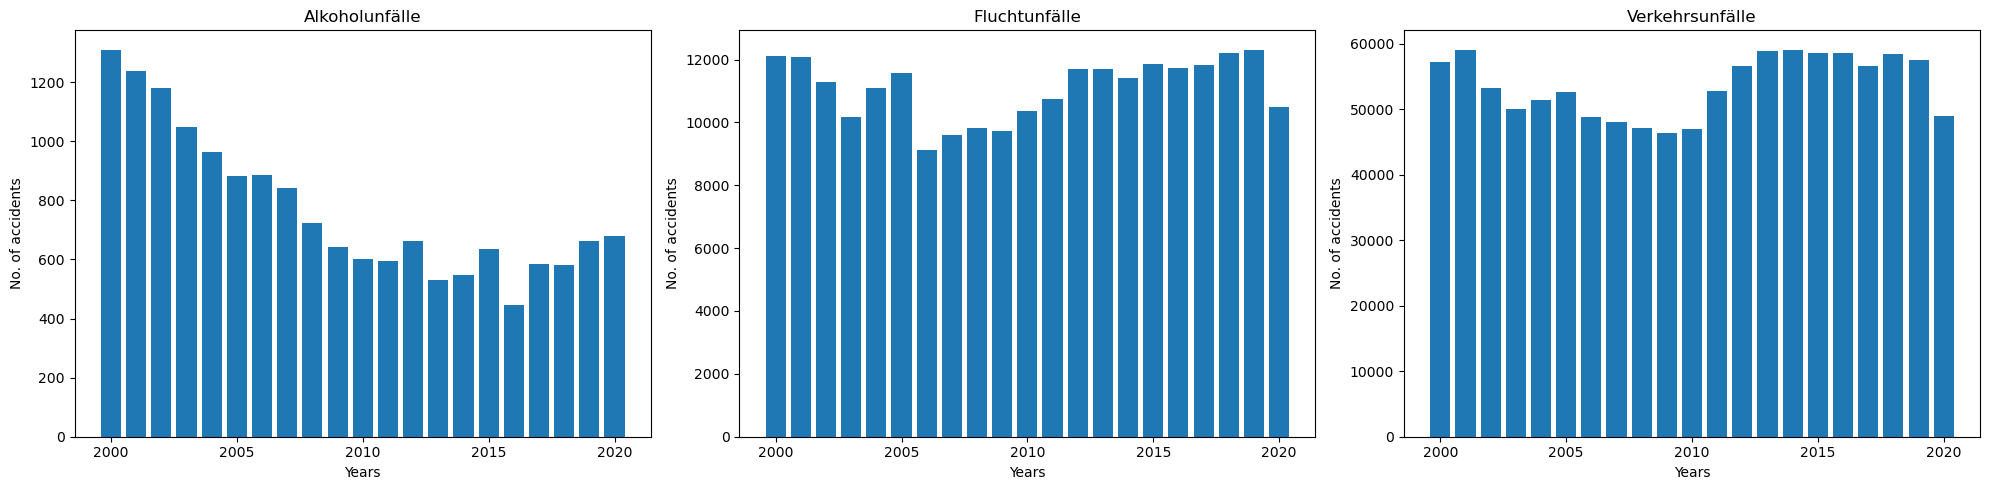

In [18]:
years = np.unique(data_2020[:,2]).astype('int')

fig, axs = plt.subplots(1,3, figsize=(20, 5))
axs = axs.ravel()
formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")

for i,category in enumerate(categories):
  accidents_per_year= []
  cat_masked = data_2020[data_2020[:,0] == categories_mapping[category]]
  for year in years:
    year_masked = cat_masked[cat_masked[:,2]==year]
    num_accident = np.sum(year_masked[:,4])
    accidents_per_year.append(num_accident)
    
  axs[i].bar(years,accidents_per_year)
  axs[i].set_title(category)
  axs[i].set(xlabel="Years",ylabel="No. of accidents")
  axs[i].xaxis.set_major_formatter(formatter)
  fig.tight_layout()
  
plt.savefig('category_per_year.png')


Plot number of accidents per month in chosen years

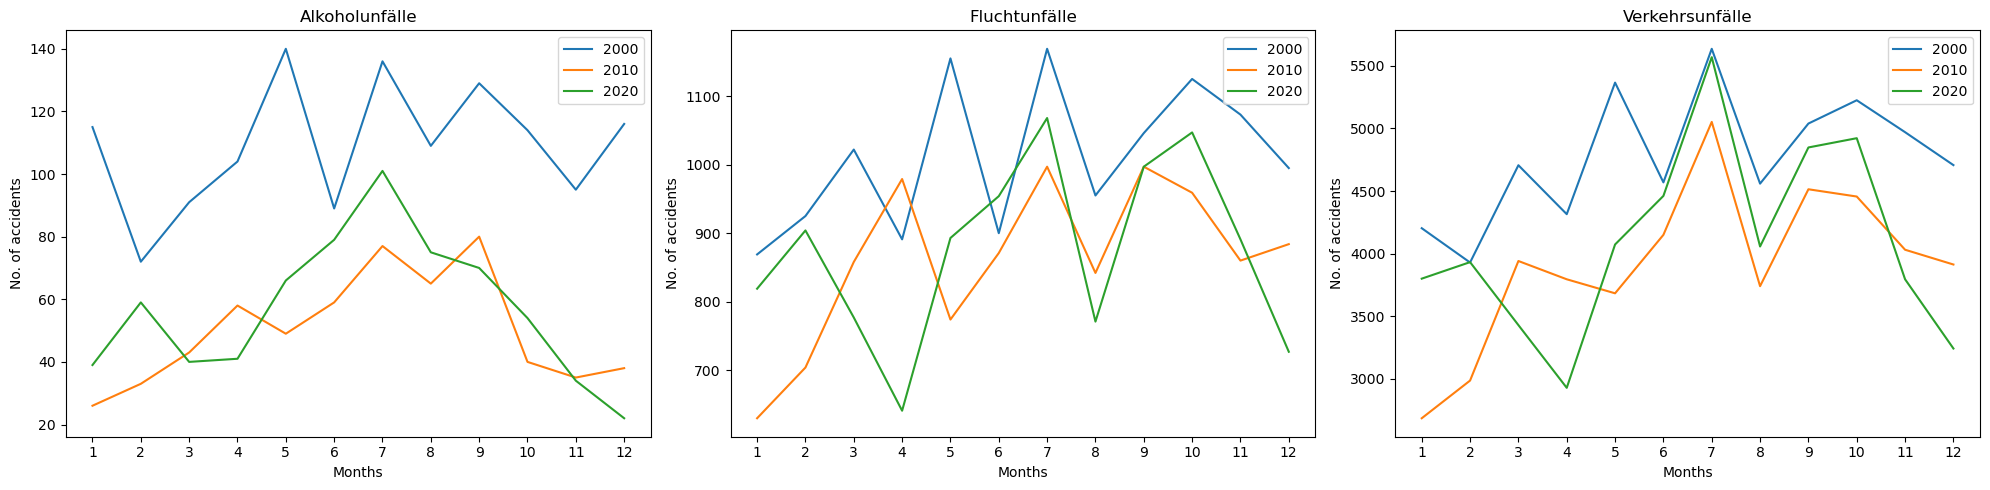

In [71]:
sample_years = [2000,2010,2020]
# plot number of accidents per month per category in (3,3) grid for each year in sample_years
# plots of same category are in the same row
# plots of same year are in the same column

fig, axs = plt.subplots(1,len(categories), figsize=(20, 5))
axs = axs.ravel()
formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")

for i,year in enumerate(sample_years):
  for j,category in enumerate(categories):
    accidents_per_month= []
    cat_masked = data_2020[data_2020[:,0] == categories_mapping[category]]
    year_masked = cat_masked[cat_masked[:,2]==year]
    for month in range(1,13):
      month_masked = year_masked[year_masked[:,3]==month]

      num_accident = np.sum(month_masked[:,4])
      accidents_per_month.append(num_accident)
    
    axs[j].plot(range(1,13),accidents_per_month)
    axs[j].set_title(category)
    axs[j].set(xlabel="Months",ylabel="No. of accidents")
    axs[j].xaxis.set_major_formatter(formatter)
    axs[j].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    axs[j].legend(sample_years,loc="upper right")
    fig.tight_layout()
  
plt.savefig('category_per_month_' +  '_'.join(map(str, sample_years)) +'.png')

## Prepare Train and Test Setup

In [ ]:
train_years = years[:int(np.round(len(years)*0.8))] 
test_years = years[len(train_years):]
print("Split year:",train_years[-1])
print("Train years:",train_years)
print("Test years:",test_years)

Split year: 2016
Train years: [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016]
Test years: [2017 2018 2019 2020]


In [ ]:
# split train and test data by years
train_data = data_2020[data_2020[:,2] <= train_years[-1]]
test_data = data_2020[data_2020[:,2] > train_years[-1]]

print(train_data.shape)
print(test_data.shape)

# split features and the label
X_train = train_data[:,0:4]
y_train = train_data[:,4]

X_test = test_data[:,0:4] 
y_test = test_data[:,4]

(1428, 5)
(336, 5)


In [ ]:
# Define model
model = xgb.XGBRegressor(n_estimators=1000)

# Train the model 
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (Test): {mse_test}')

Mean Squared Error (Test): 35903.1130387139


In [ ]:
model.predict(np.array([[categories_mapping['Alkoholunfälle'],types_mapping['insgesamt'],2021,1]]))

array([20.530388], dtype=float32)

TODO: 
- Make graphs appear in line: done
- Make graphs more detailed: done
- Try including type info in graphs: no
- Saving images: done
- Explanation / Titles for sections
- test for a different model
- calculate error differently
- plot prediction sover real data
- check cross-validation time split
- deploy